In [1]:
# create table tt_q_tag_cnt as 
# select x.id
# 	, to_char(x.creationdate, 'yyyy-mm-dd') as c_date
# 	, (regexp_matches(x.tags, '<(ruby|scala|rust|go|bash|shell|objective-c|python|r|typescript|swift|c#|sql|assembly|kotlin|c\+\+|javascript|vba|c|html|css|java|perl|haskell|julia|php|dart|clojure|f#|elixir|erlang|lisp|groovy|crystal-lang|powershell|cobol|delphi|matlab)>', 'g'))[1] AS matched_tags
# 	, x.tag
#   from (
# 	select id, creationdate, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag 
#   from posts
# where posttypeid ='1'
#   and (tags like '%<ruby>%' or tags like '%<scala>%' or tags like '%<rust>%' or tags like '%<go>%' or tags like '%<bash>%' or tags like '%<shell>%' or tags like '%<objective-c>%' or tags like '%<python>%' or tags like '%<r>%' or tags like '%<typescript>%' or tags like '%<swift>%' or tags like '%<c#>%' or tags like '%<sql>%' or tags like '%<assembly>%' or tags like '%<kotlin>%' or tags like '%<c++>%' or tags like '%<javascript>%' or tags like '%<vba>%' or tags like '%<c>%' or tags like '%<html>%' or tags like '%<css>%' or tags like '%<java>%' or tags like '%<perl>%' or tags like '%<haskell>%' or tags like '%<julia>%' or tags like '%<php>%' or tags like '%<dart>%' or tags like '%<clojure>%' or tags like '%<f#>%' or tags like '%<elixir>%' or tags like '%<erlang>%' or tags like '%<lisp>%' or tags like '%<groovy>%' or tags like '%<crystal-lang>%' or tags like '%<powershell>%' or tags like '%<cobol>%' or tags like '%<delphi>%' or tags like '%<matlab>%')
#   and creationdate between '2021-11-30' and '2023-12-03' 
#   ) x 
# ;

In [2]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

In [3]:
import json
import pandas as pd
import numpy as np
from utils.salary import *
import psycopg2
from utils.statistics import *
import config.config as conf
import datetime
import re
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn as sns
import matplotlib.pyplot as plt

## 데이터전처리

In [4]:
output_dir = '../figs/tag/'
by = 'rel_week'

In [5]:
# test.json 내용: [{"name":"Jack","age":26},{"name":"Ace","age":87}]
df = pd.read_json('../result/tag/salary.json') ## pd.read_json 이용

In [6]:
df = df.reset_index().rename(columns={'index':'year'})

In [7]:
df = df.sort_values(by = 'year').reset_index(drop=True)

In [8]:
df

,year,clojure,f#,elixir,erlang,perl,ruby,scala,rust,go,...,zig,apex,nim-lang,raku,ada,prolog,gdscript,vb.net,micropython,zephyr-rtos
0,2019,90000.0,80000.0,76000.0,71000.0,NaN,75000,78000,72000,80000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,NaN,NaN,NaN,76000.0,71000,76000,74000,74000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,95000.0,81037.0,80077.0,80077.0,80000.0,80000,77832,77530,75669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022,106644.0,95526.0,92959.0,103000.0,90073.0,93000,92780,87047,89204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023,96381.0,99311.0,96381.0,99492.0,94540.0,98522,96381,87012,92760,...,103611.0,81552.0,80000.0,79448.0,71500.0,70000.0,69608.0,65000.0,NaN,NaN
5,2024,95541.0,80555.0,96000.0,100636.0,90000.0,90221,88619,76292,76433,...,75332.0,82500.0,94924.0,NaN,42584.0,43327.0,60684.0,63694.0,75184.0,64444.0


In [9]:
def get_CID_ratio_df(df, year) : 
    year_list = [year-3, year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    filtered_df = df_salary[df_salary['lang'].isin(df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index)].copy()
    filtered_df['salary_ratio'] = filtered_df.groupby(['lang'])['salary'].transform(lambda x: x/x.shift(1) )
    filtered_df = filtered_df.dropna()

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['salary_ratio'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['CID'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)


    return filtered_df




In [10]:
def get_CID_df(df, year) : 
    year_list = [year-2, year-1, year]
    print(year_list)
    df = df = df[df['year'].isin(year_list)]
    df_salary = df.melt(id_vars = 'year', value_vars = df.columns[1:], var_name = 'lang', value_name = 'salary')
    df_salary = df_salary.dropna()

    filtered_df = df_salary[df_salary['lang'].isin(df_salary['lang'].value_counts()[lambda x: x == len(year_list)].index)].copy()
    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['salary'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)

    filtered_df.loc[ : , 'CID'] = filtered_df.sort_values(by = ['lang', 'year'], ascending=[True, True]).groupby(['lang'])['CID'].diff()
    filtered_df = filtered_df.dropna().reset_index(drop=True)


    return filtered_df




In [11]:
def filter_df( df, type ) :
    tot_filtered_df = pd.DataFrame()
    for year in [ 2022, 2023, 2024] : 
        if type == 'ratio' : 
            filtered_df = get_CID_ratio_df(df, year)
        else :
            filtered_df = get_CID_df(df, year)
            
        tot_filtered_df = pd.concat([tot_filtered_df, filtered_df], axis = 0)
    
        tot_exist_df = tot_filtered_df[tot_filtered_df['lang'].isin(tot_filtered_df['lang'].value_counts()[lambda x: x == len([ 2022, 2023, 2024])].index)].copy()
        tot_exist_df=  tot_exist_df.sort_values(by = ['year', 'CID'], ascending=[False, True])
    return tot_exist_df

In [12]:
tot_df_r = filter_df(df, 'ratio')

tot_df_nr = filter_df(df, 'not_ratio')

[2019, 2020, 2021, 2022]
[2020, 2021, 2022, 2023]
[2021, 2022, 2023, 2024]
[2020, 2021, 2022]
[2021, 2022, 2023]
[2022, 2023, 2024]


In [13]:
cid_2024 = tot_df_r[tot_df_r['year'] == 2024].sort_values(by = ['CID'], ascending=[False])

In [14]:
cid_2024.head()

,year,lang,salary,salary_ratio,CID
23,2024,assembly,60834.0,0.789949,0.094774
6,2024,scala,88619.0,0.919465,0.033896
27,2024,vba,64444.0,0.980913,0.030750
7,2024,rust,76292.0,0.876799,0.000355
20,2024,swift,75184.0,0.865208,-0.017633


## 데이터 로드

In [15]:
# conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
# try:
#     cur = conn.cursor()
#     cur.execute("\
# select c_date, matched_tags, tag, count(*) as cnt \
#   from tt_q_tag_cnt \
#  group by c_date, matched_tags, tag \
# ; \
#                 " 
#    )
#     rows = cur.fetchall()
    

# except psycopg2.DatabaseError as db_err:
#     print(db_err)
# finally : 
#   cur.close()

In [16]:
# conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
# try:
#     cur = conn.cursor()
#     cur.execute("\
# select c_date, matched_tags, tag, sum(prop_for_t) as cnt \
#   from tt_q_tag_cnt_02 \
#  group by c_date, matched_tags, tag \
# ; \
#                 " 
#    )
#     rows = cur.fetchall()
    

# except psycopg2.DatabaseError as db_err:
#     print(db_err)
# finally : 
#   cur.close()

In [17]:
str([x for x in cid_2024['lang']])[1:-1]

"'assembly', 'scala', 'vba', 'rust', 'swift', 'ruby', 'objective-c', 'sql', 'bash/shell', 'go', 'c#', 'c++', 'c', 'html/css', 'python', 'typescript', 'kotlin', 'java', 'javascript', 'r'"

In [18]:
q_string =  f"select c_date, matched_tags, tag, sum(prop_for_t) as cnt from tt_q_tag_cnt_02 where matched_tags in ({str([x for x in cid_2024['lang']])[1:-1]}) group by c_date, matched_tags, tag; "

In [19]:
q_string

"select c_date, matched_tags, tag, sum(prop_for_t) as cnt from tt_q_tag_cnt_02 where matched_tags in ('assembly', 'scala', 'vba', 'rust', 'swift', 'ruby', 'objective-c', 'sql', 'bash/shell', 'go', 'c#', 'c++', 'c', 'html/css', 'python', 'typescript', 'kotlin', 'java', 'javascript', 'r') group by c_date, matched_tags, tag; "

In [20]:
# CID를 다시 계산함에 따라 시각화에 사용할 언어 변경(2020년부터 2024년까지 모든 SALARY 데이터가 존재하는 언어를 대상으로 )
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute(q_string)
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [21]:
tag_dis_df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'matched_tags' 
, 'tag'
, 'cnt'
])

In [22]:
tag_dis_df.head()

,cdate,matched_tags,tag,cnt
0,2021-01-01,assembly,arm,0.50000000000000000000
1,2021-01-01,assembly,assembly,3.84999999999999999999
2,2021-01-01,assembly,c,0.78333333333333333333
3,2021-01-01,assembly,cpu-architecture,0.20000000000000000000
4,2021-01-01,assembly,cpu-registers,0.20000000000000000000


In [23]:
std_date = datetime.datetime(2022, 11, 30)

In [24]:
tag_dis_df['cdate'] = pd.to_datetime(tag_dis_df['cdate'], format="%Y-%m-%d")
tag_dis_df['rel_day'] = (tag_dis_df['cdate'] - std_date).dt.days
tag_dis_df['rel_week'] = np.floor(tag_dis_df['rel_day']/7)

In [25]:
tag_dis_df = tag_dis_df[(tag_dis_df['rel_week']>-53 ) & (tag_dis_df['rel_week']<=52 )]

In [26]:
tot_df = tag_dis_df.groupby([by, 'matched_tags'])['cnt'].sum().reset_index(name='tot_cnt')

In [27]:
tag_dis_by_df = tag_dis_df.groupby([by, 'matched_tags', 'tag'])['cnt'].sum().reset_index(name = 'cnt')

In [28]:
tag_dis_by_df.head()

,rel_week,matched_tags,tag,cnt
0,-52.0,assembly,6502,0.25000000000000000000
1,-52.0,assembly,68000,0.25000000000000000000
2,-52.0,assembly,8-bit,0.25000000000000000000
3,-52.0,assembly,8051,0.25000000000000000000
4,-52.0,assembly,addressing-mode,0.53333333333333333333


In [29]:
df_proportion = pd.merge(tag_dis_by_df, tot_df, on = [by, 'matched_tags'], how = 'left')
df_proportion['proportion'] = df_proportion['cnt'] / df_proportion['tot_cnt']
# .reset_index(name='count')

In [30]:
df_proportion.tail()

,rel_week,matched_tags,tag,cnt,tot_cnt,proportion
960465,52.0,vba,vb.net,0.33333333333333333333,97.99999999999999999974,0.003401360544217687074804942385
960466,52.0,vba,vba,40.06666666666666666658,97.99999999999999999974,0.4088435374149659863947581563
960467,52.0,vba,windows,0.91666666666666666666,97.99999999999999999974,0.009353741496598639455739101763
960468,52.0,vba,worksheet,0.33333333333333333333,97.99999999999999999974,0.003401360544217687074804942385
960469,52.0,vba,x-axis,0.20000000000000000000,97.99999999999999999974,0.002040816326530612244903373594


In [31]:
df_proportion['proportion'] = df_proportion['proportion'].astype(float)
df_proportion['tot_cnt'] = df_proportion['tot_cnt'].astype(float)

In [32]:
df_entropy = df_proportion.groupby([by, 'matched_tags'])['proportion'].apply(lambda x : calculate_entropy(x)).to_frame(name='entropy').reset_index()

In [33]:
df_entropy_viz = pd.merge(df_entropy, df_proportion[[by, 'matched_tags', 'tot_cnt']].drop_duplicates(), \
                           on = [by, 'matched_tags'], how = 'left')

In [34]:
df_proportion

,rel_week,matched_tags,tag,cnt,tot_cnt,proportion
0,-52.0,assembly,6502,0.25000000000000000000,66.0,0.003788
1,-52.0,assembly,68000,0.25000000000000000000,66.0,0.003788
2,-52.0,assembly,8-bit,0.25000000000000000000,66.0,0.003788
3,-52.0,assembly,8051,0.25000000000000000000,66.0,0.003788
4,-52.0,assembly,addressing-mode,0.53333333333333333333,66.0,0.008081
...,...,...,...,...,...,...
960465,52.0,vba,vb.net,0.33333333333333333333,98.0,0.003401
960466,52.0,vba,vba,40.06666666666666666658,98.0,0.408844
960467,52.0,vba,windows,0.91666666666666666666,98.0,0.009354
960468,52.0,vba,worksheet,0.33333333333333333333,98.0,0.003401


In [35]:
df_entropy_viz['log_tot_cnt'] = np.log(df_entropy_viz['tot_cnt'])

In [36]:
cid_2024

,year,lang,salary,salary_ratio,CID
23,2024,assembly,60834.0,0.789949,0.094774
6,2024,scala,88619.0,0.919465,0.033896
27,2024,vba,64444.0,0.980913,0.030750
7,2024,rust,76292.0,0.876799,0.000355
20,2024,swift,75184.0,0.865208,-0.017633
5,2024,ruby,90221.0,0.915745,-0.040508
16,2024,objective-c,73648.0,0.818311,-0.063818
22,2024,sql,64919.0,0.866014,-0.074364
12,2024,bash/shell,75184.0,0.877580,-0.075784
8,2024,go,76433.0,0.823987,-0.076870


In [37]:
lang_t5_2024 = list(cid_2024['lang'])[:5]
lang_b5_2024 = list(cid_2024['lang'])[-5:]

In [38]:
# lang_t5_2024.append('python')
# # lang_b5_2024.append('python')

In [39]:
df_entropy_viz_bf = df_entropy_viz[df_entropy_viz[by]<0]
df_entropy_viz_af = df_entropy_viz[df_entropy_viz[by]>=0]

In [40]:
def get_loss_dict(lan_list) : 
    smoothed_bf_dict = dict()
    smoothed_af_dict = dict()
    return_dict = dict()

    for lang in lan_list:
        df_entropy_viz_bf_p = df_entropy_viz_bf[df_entropy_viz_bf['matched_tags'] ==lang]
        df_entropy_viz_af_p = df_entropy_viz_af[df_entropy_viz_af['matched_tags'] ==lang]

        smoothed_bf_dict[lang] = lowess(df_entropy_viz_bf_p['entropy'], df_entropy_viz_bf_p['log_tot_cnt'], frac=0.5)
        smoothed_af_dict[lang] = lowess(df_entropy_viz_af_p['entropy'], df_entropy_viz_af_p['log_tot_cnt'], frac=0.5)
    
    return_dict[0] = smoothed_bf_dict
    return_dict[1] = smoothed_af_dict
    return return_dict




In [41]:
t5_dict = get_loss_dict(lang_t5_2024)
b5_dict = get_loss_dict(lang_b5_2024)

In [42]:
tb5_dict = {0:t5_dict, 1:b5_dict}

In [43]:
tb5_dict[0][0]

{'assembly': array([[3.40119738, 3.23711079],
        [3.4339872 , 3.24629792],
        [3.4657359 , 3.25570194],
        [3.49650756, 3.26525717],
        [3.58351894, 3.29220062],
        [3.63758616, 3.3054754 ],
        [3.66356165, 3.30927869],
        [3.68887945, 3.31480847],
        [3.68887945, 3.31480847],
        [3.68887945, 3.31480847],
        [3.71357207, 3.32611017],
        [3.71357207, 3.32611017],
        [3.76120012, 3.34952299],
        [3.76120012, 3.34952299],
        [3.76120012, 3.34952299],
        [3.78418963, 3.35972292],
        [3.87120101, 3.37558295],
        [3.87120101, 3.37558295],
        [3.8918203 , 3.37873803],
        [3.8918203 , 3.37873803],
        [3.91202301, 3.37928669],
        [3.91202301, 3.37928669],
        [3.93182563, 3.38681799],
        [3.95124372, 3.39384217],
        [3.97029191, 3.40318751],
        [3.97029191, 3.40318751],
        [3.98898405, 3.41226726],
        [4.00733319, 3.4174733 ],
        [4.02535169, 3.42373017],
  

['assembly', 'scala', 'vba', 'rust', 'swift']


ValueError: Could not interpret value `gini` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x1200 with 0 Axes>

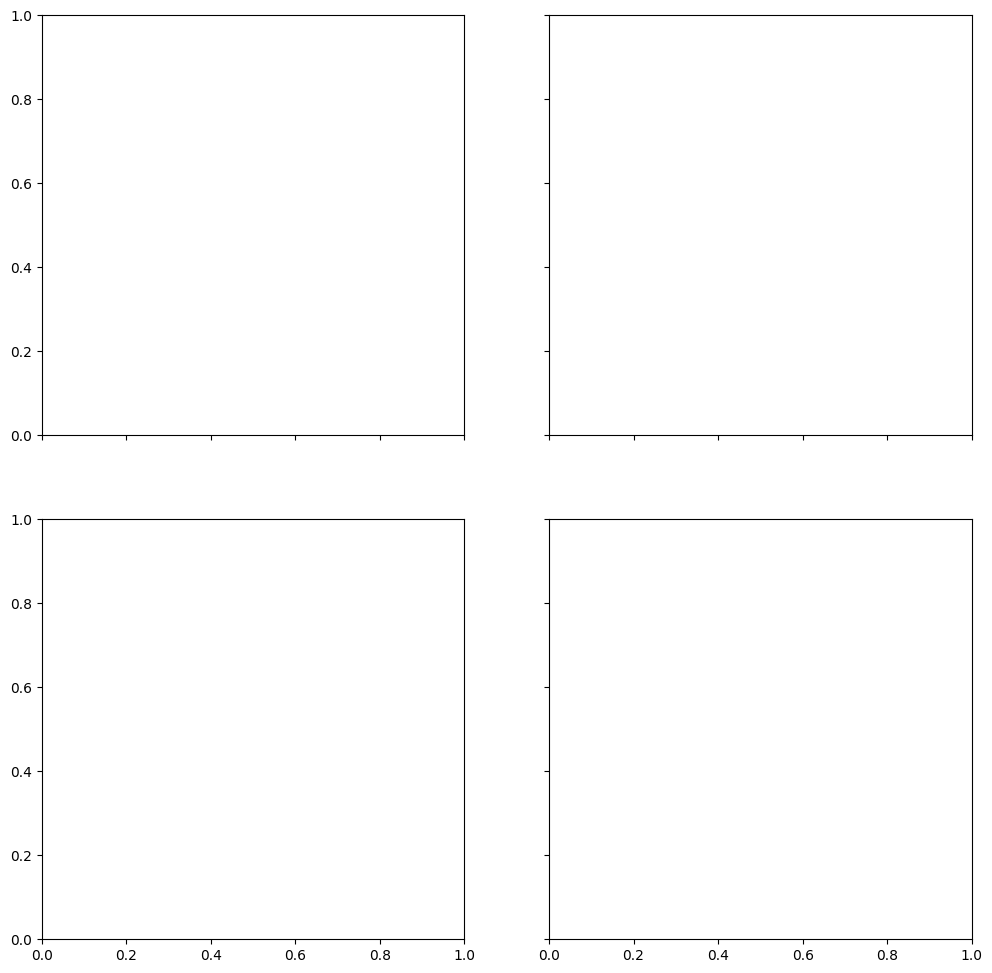

In [ ]:
palette_dict = dict()
palette_dict[0] = sns.color_palette("gist_ncar")
palette_dict[1] = sns.color_palette("gist_rainbow")

# 도화지 초기화
plt.figure(figsize=(12, 12))
fig, axs = plt.subplots( 2, 2,  figsize = (12, 12), sharey=True, sharex=True)

for s_idx in range(0, 2):
    bf_dict = tb5_dict[s_idx][0]
    af_dict = tb5_dict[s_idx][1]
    lang_order = list(bf_dict.keys())
    
    print(lang_order)

    sns.scatterplot(
        data=df_entropy_viz_bf,
        x="log_tot_cnt",
        y="entropy",
        color="gray",       # 회색 점
        alpha=0.1,          # 투명도
        s=20,                # 점 크기 (면적 기준)
        ax=axs[s_idx][0])
    axs[s_idx][0].set_title("A. Before ChatGPT")
    axs[s_idx][0].set_ylabel("Entropy")
    axs[s_idx][0].set_xlabel("logN")
    axs[s_idx][0].grid(axis='y', linestyle='--', linewidth=0.5)    
    for idx, lang in enumerate(lang_order):
        print(lang)
        axs[s_idx][0].plot(bf_dict[lang][:, 0], bf_dict[lang][:, 1], color=palette_dict[s_idx][idx], lw=1.5, label = lang)
    for idx, lang in enumerate(lang_order):
        print(lang)
        axs[s_idx][0].plot(bf_dict[lang][:, 0], bf_dict[lang][:, 1], color=palette_dict[s_idx][idx], lw=1.5, label = lang)
    axs[s_idx][0].legend()

    sns.scatterplot(
        data=df_entropy_viz_af,
        x="log_tot_cnt",
        y="entropy",
        color="gray",       # 회색 점
        alpha=0.1,          # 투명도
        s=20,                # 점 크기 (면적 기준)
        ax=axs[s_idx][1])
    axs[s_idx][1].set_title("B. After ChatGPT")
    axs[s_idx][1].set_ylabel("Entropy")
    axs[s_idx][1].set_xlabel("logN")
    axs[s_idx][1].grid(axis='y', linestyle='--', linewidth=0.5)
    for idx, lang in enumerate(lang_order):
        axs[s_idx][1].plot(af_dict[lang][:, 0], af_dict[lang][:, 1], color=palette_dict[s_idx][idx], lw=1.5, label = lang)
    axs[s_idx][1].legend()

# 범례 및 레이아웃 정리
# plt.legend(title="Year")
plt.tight_layout()
plt.show();


['assembly', 'scala', 'vba', 'rust', 'swift']
assembly
scala
vba
rust
swift
['typescript', 'kotlin', 'java', 'javascript', 'r']
typescript
kotlin
java
javascript
r


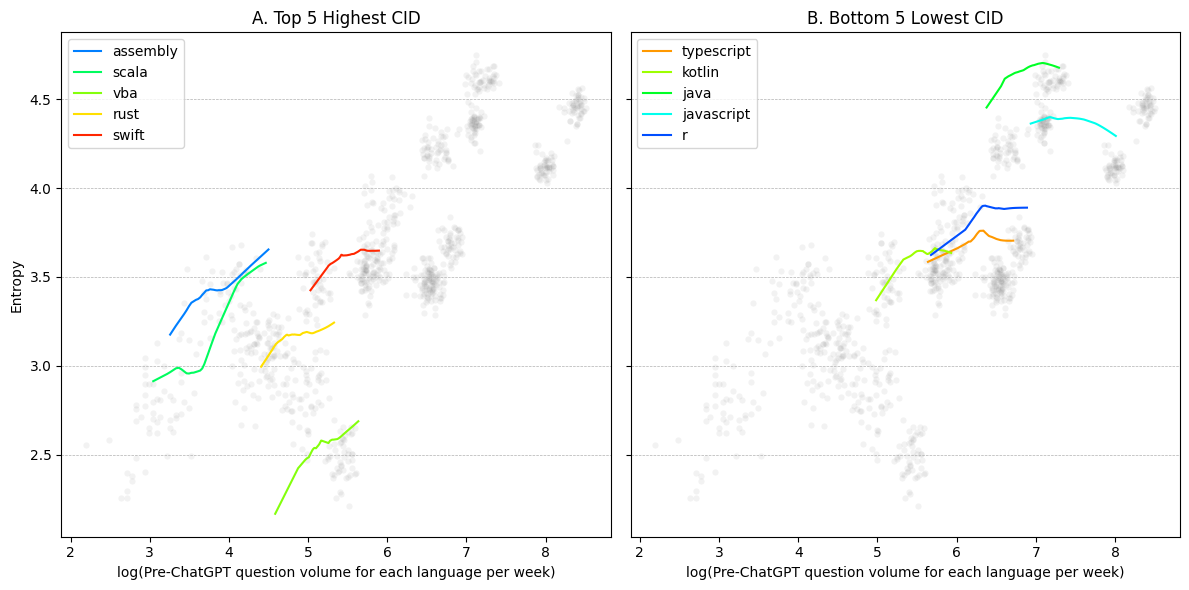

In [45]:
palette_dict = dict()
palette_dict[0] = sns.color_palette("gist_ncar")
palette_dict[1] = sns.color_palette("gist_rainbow")

# 도화지 초기화
fig, axs = plt.subplots( 1, 2,  figsize = (12, 6), sharey=True, sharex=True)
title_dict = {0 : 'A. Top 5 Highest CID', 1 : 'B. Bottom 5 Lowest CID'}

for s_idx in range(0, 2):
    bf_dict = tb5_dict[s_idx][1]
    
    lang_order = list(bf_dict.keys())
    print(lang_order)

    sns.scatterplot(
        data=df_entropy_viz_bf,
        x="log_tot_cnt",
        y="entropy",
        color="gray",       # 회색 점
        alpha=0.1,          # 투명도
        s=20,                # 점 크기 (면적 기준)
        ax=axs[s_idx])
    axs[s_idx].set_title(f"{title_dict[s_idx]}")
    axs[s_idx].set_ylabel("Entropy")
    axs[s_idx].set_xlabel("log(Pre-ChatGPT question volume for each language per week)")
    axs[s_idx].grid(axis='y', linestyle='--', linewidth=0.5)    
    for idx, lang in enumerate(lang_order):
        print(lang)
        axs[s_idx].plot(bf_dict[lang][:, 0], bf_dict[lang][:, 1], color=palette_dict[s_idx][idx], lw=1.5, label = lang)
    axs[s_idx].legend()


# 범례 및 레이아웃 정리
# plt.legend(title="Year")
plt.tight_layout()
plt.show();


In [ ]:
from sklearn.linear_model import LinearRegression

def get_slope_dict(lan_list) : 
    smoothed_bf_dict = dict()
    smoothed_af_dict = dict()
    return_dict = dict()

    for lang in lan_list:
        df_entropy_viz_bf_p = df_entropy_viz_bf[df_entropy_viz_bf['matched_tags'] ==lang]
        df_entropy_viz_af_p = df_entropy_viz_af[df_entropy_viz_af['matched_tags'] ==lang]

        model_before    = LinearRegression().fit(df_entropy_viz_bf_p['log_tot_cnt'].values.reshape(-1, 1), df_entropy_viz_bf_p['entropy'].values.reshape(-1, 1))
        model_after     = LinearRegression().fit(df_entropy_viz_af_p['log_tot_cnt'].values.reshape(-1, 1), df_entropy_viz_af_p['entropy'].values.reshape(-1, 1))

        slope_before = model_before.coef_[0]
        slope_after = model_after.coef_[0]

        print(lang, slope_before, slope_after, np.where(np.abs(slope_before) > np.abs(slope_after), 'af!', 'bf!'))

    
    # return_dict[0] = smoothed_bf_dict
    # return_dict[1] = smoothed_af_dict
    # return return_dict




In [47]:
df_entropy_viz_bf = df_entropy_viz[df_entropy_viz[by]<0]
df_entropy_viz_af = df_entropy_viz[df_entropy_viz[by]>=0]

In [48]:
df_entropy_viz_bf_p = df_entropy_viz_bf[df_entropy_viz_bf['matched_tags'] =='r']
df_entropy_viz_af_p = df_entropy_viz_af[df_entropy_viz_af['matched_tags'] =='r']

In [52]:
df_entropy_viz_bf_p

,rel_week,matched_tags,entropy,tot_cnt,log_tot_cnt
10,-52.0,r,3.585597,954.0,6.860664
28,-51.0,r,3.691358,897.0,6.799056
46,-50.0,r,3.634039,848.0,6.742881
64,-49.0,r,3.501381,557.0,6.322565
82,-48.0,r,3.605610,633.0,6.450470
100,-47.0,r,3.764345,829.0,6.720220
118,-46.0,r,3.680739,872.0,6.770789
136,-45.0,r,3.761229,987.0,6.894670
154,-44.0,r,3.628604,975.0,6.882437
172,-43.0,r,3.643122,1009.0,6.916715


In [53]:
df_entropy_viz_af_p

,rel_week,matched_tags,entropy,tot_cnt,log_tot_cnt
946,0.0,r,3.723611,952.0,6.858565
964,1.0,r,3.856578,939.0,6.844815
982,2.0,r,3.851046,919.0,6.823286
1000,3.0,r,3.877179,629.0,6.444131
1018,4.0,r,3.867238,592.0,6.383507
1036,5.0,r,3.890110,832.0,6.723832
1054,6.0,r,3.868952,847.0,6.741701
1072,7.0,r,3.875005,858.0,6.754604
1090,8.0,r,3.876375,967.0,6.874198
1108,9.0,r,3.891616,981.0,6.888572


In [49]:
get_slope_dict(lang_t5_2024)
get_slope_dict(lang_b5_2024)

assembly [0.27538422] [0.31293333] ['bf!']
scala [0.34350858] [0.63793181] ['bf!']
vba [0.08497229] [0.31871876] ['bf!']
rust [0.19411444] [0.16619463] ['af!']
swift [-0.01877849] [0.17271476] ['bf!']
typescript [0.2204082] [0.05368247] ['af!']
kotlin [0.03219875] [0.16008388] ['bf!']
java [0.08976649] [0.18311184] ['bf!']
javascript [0.02203528] [-0.09718519] ['bf!']
r [0.18143008] [0.10923639] ['af!']


In [50]:
df_entropy_viz

,rel_week,matched_tags,entropy,tot_cnt,log_tot_cnt
0,-52.0,assembly,3.524966,66.0,4.189655
1,-52.0,c,3.956435,553.0,6.315358
2,-52.0,c#,4.381750,1187.0,7.079184
3,-52.0,c++,4.121391,920.0,6.824374
4,-52.0,go,3.470481,157.0,5.056246
...,...,...,...,...,...
1885,52.0,scala,3.184345,25.0,3.218876
1886,52.0,sql,3.447426,219.0,5.389072
1887,52.0,swift,3.392896,153.0,5.030438
1888,52.0,typescript,3.587096,281.0,5.638355


<Figure size 1200x1200 with 0 Axes>

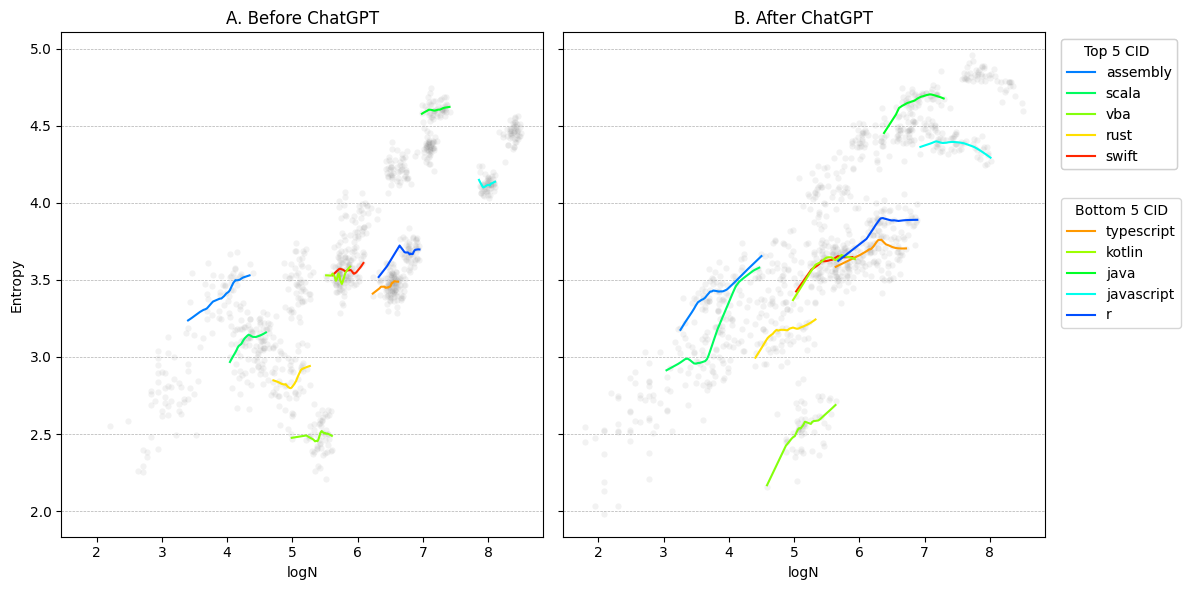

In [51]:
palette_dict = dict()
palette_dict[0] = sns.color_palette("gist_ncar")
palette_dict[1] = sns.color_palette("gist_rainbow")

df_dict = dict()
df_dict[0] = df_entropy_viz_bf
df_dict[1] = df_entropy_viz_af

# 도화지 초기화
plt.figure(figsize=(12, 12))
fig, axs = plt.subplots( 1, 2,  figsize = (12, 6), sharey=True, sharex=True)

bf_dict_t = tb5_dict[0][0]
bf_dict_b = tb5_dict[1][0]

af_dict_t = tb5_dict[0][1]
af_dict_b = tb5_dict[1][1]

bt_lang_order = list(bf_dict_t.keys())
bb_lang_order = list(bf_dict_b.keys())
at_lang_order = list(af_dict_t.keys())

top5_lines = []
bottom5_lines = []

ab_lang_order = list(af_dict_b.keys())

for s_idx in range(0, 2):    
    sns.scatterplot(
        data=df_dict[s_idx],
        x="log_tot_cnt",
        y="entropy",
        color="gray",       # 회색 점
        alpha=0.1,          # 투명도
        s=20,                # 점 크기 (면적 기준)
        ax=axs[s_idx])
    axs[s_idx].set_title("A. Before ChatGPT" if s_idx == 0 else "B. After ChatGPT")
    axs[s_idx].set_ylabel("Entropy")
    axs[s_idx].set_xlabel("logN")
    axs[s_idx].grid(axis='y', linestyle='--', linewidth=0.5)    
    if s_idx == 0 : # before
        for idx, lang in enumerate(bt_lang_order):
            line, = axs[s_idx].plot(bf_dict_t[lang][:, 0], bf_dict_t[lang][:, 1], color=palette_dict[0][idx], lw=1.5, label = lang)
            top5_lines.append(line)
        for idx, lang in enumerate(bb_lang_order):
            line, = axs[s_idx].plot(bf_dict_b[lang][:, 0], bf_dict_b[lang][:, 1], color=palette_dict[1][idx], lw=1.5, label = lang)     
            bottom5_lines.append(line)       
    else : 
        for idx, lang in enumerate(at_lang_order):
            axs[s_idx].plot(af_dict_t[lang][:, 0], af_dict_t[lang][:, 1], color=palette_dict[0][idx], lw=1.5, label = lang)
        for idx, lang in enumerate(ab_lang_order):
            axs[s_idx].plot(af_dict_b[lang][:, 0], af_dict_b[lang][:, 1], color=palette_dict[1][idx], lw=1.5, label = lang)
    # axs[s_idx].legend()
    # 2. 첫 번째 레전드 (상위 5개)
    legend1 = axs[1].legend(handles=top5_lines, title='Top 5 CID ', loc='upper left', bbox_to_anchor=(1.02, 1))
    axs[1].add_artist(legend1)  # 첫 번째 레전드 고정

    # 3. 두 번째 레전드 (하위 5개)
    legend2 = axs[1].legend(handles=bottom5_lines, title='Bottom 5 CID', loc='lower left', bbox_to_anchor=(1.02, 0.4))

# 범례 및 레이아웃 정리
# plt.legend(title="Year")
plt.tight_layout()
plt.show();


In [55]:
df_entropy_viz

,rel_week,matched_tags,entropy,tot_cnt,log_tot_cnt
0,-52.0,assembly,3.524966,66.0,4.189655
1,-52.0,c,3.956435,553.0,6.315358
2,-52.0,c#,4.381750,1187.0,7.079184
3,-52.0,c++,4.121391,920.0,6.824374
4,-52.0,go,3.470481,157.0,5.056246
...,...,...,...,...,...
1885,52.0,scala,3.184345,25.0,3.218876
1886,52.0,sql,3.447426,219.0,5.389072
1887,52.0,swift,3.392896,153.0,5.030438
1888,52.0,typescript,3.587096,281.0,5.638355


In [57]:
import pandas as pd
from scipy.stats import ks_2samp, mannwhitneyu

# 예시 데이터: DataFrame 형태
# 'language' : 프로그래밍 언어
# 'period' : 'before' 또는 'after'
# 'entropy' : 엔트로피 값
# (당연히 실제 데이터프레임에는 이 세 컬럼이 있어야 합니다)

# 데이터 예시
# df = pd.read_csv('your_entropy_data.csv')  # 혹은 준비된 DataFrame
# df.head()

# 결과 저장할 리스트
results = []

# 분석할 언어 리스트 (예시)
languages = df_entropy_viz['matched_tags'].unique()

for lang in languages:
    # 언어별 데이터 분리
    df_lang = df_entropy_viz[df_entropy_viz['matched_tags'] == lang]
    entropy_before = df_lang[df_lang['rel_week'] < 0]['entropy']
    entropy_after  = df_lang[df_lang['rel_week'] >= 0]['entropy']
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = ks_2samp(entropy_before, entropy_after)
    
    # Mann-Whitney U test
    mw_stat, mw_pvalue = mannwhitneyu(entropy_before, entropy_after, alternative='two-sided')
    
    # 평균 엔트로피 비교 (변화 방향)
    mean_before = entropy_before.mean()
    mean_after  = entropy_after.mean()
    if mean_after > mean_before:
        direction = 'Increase (↑)'
    else:
        direction = 'Decrease (↓)'
    
    results.append({
        'Language': lang,
        'KS_pvalue': ks_pvalue,
        'MW_pvalue': mw_pvalue,
        'Mean_Before': mean_before,
        'Mean_After': mean_after,
        'Change_Direction': direction
    })

# 결과를 DataFrame으로
results_df = pd.DataFrame(results)
print(results_df)


       Language     KS_pvalue     MW_pvalue  Mean_Before  Mean_After  \
0      assembly  2.199296e-01  2.773264e-01     3.399796    3.376487   
1             c  1.046943e-09  1.168540e-11     3.853464    4.050379   
2            c#  8.428130e-18  4.450096e-15     4.354199    4.461986   
3           c++  9.184795e-15  1.225379e-14     4.216737    4.396075   
4            go  5.130706e-02  2.050944e-02     3.478390    3.544969   
5          java  3.159792e-08  3.889071e-08     4.606085    4.670533   
6    javascript  6.377017e-31  1.060355e-18     4.119059    4.376109   
7        kotlin  3.270256e-07  7.429893e-08     3.523366    3.626088   
8   objective-c  4.188060e-02  3.996394e-02     2.721702    2.614971   
9        python  6.377017e-31  1.060355e-18     4.455453    4.804284   
10            r  3.900355e-19  2.806213e-15     3.680124    3.868139   
11         ruby  8.012224e-01  3.993411e-01     3.051632    3.080593   
12         rust  8.863870e-17  4.928058e-15     2.845173    3.16

In [59]:
# 유의미한 결과만 필터링
significant_changes = results_df[(results_df['KS_pvalue'] < 0.05) | (results_df['MW_pvalue'] < 0.05)]


In [73]:
significant_changes

,Language,KS_pvalue,MW_pvalue,Mean_Before,Mean_After,Change_Direction
1,c,1.046943e-09,1.168540e-11,3.853464,4.050379,Increase (↑)
2,c#,8.428130e-18,4.450096e-15,4.354199,4.461986,Increase (↑)
3,c++,9.184795e-15,1.225379e-14,4.216737,4.396075,Increase (↑)
4,go,5.130706e-02,2.050944e-02,3.478390,3.544969,Increase (↑)
5,java,3.159792e-08,3.889071e-08,4.606085,4.670533,Increase (↑)
6,javascript,6.377017e-31,1.060355e-18,4.119059,4.376109,Increase (↑)
7,kotlin,3.270256e-07,7.429893e-08,3.523366,3.626088,Increase (↑)
8,objective-c,4.188060e-02,3.996394e-02,2.721702,2.614971,Decrease (↓)
9,python,6.377017e-31,1.060355e-18,4.455453,4.804284,Increase (↑)
10,r,3.900355e-19,2.806213e-15,3.680124,3.868139,Increase (↑)


In [66]:
results_df

,Language,KS_pvalue,MW_pvalue,Mean_Before,Mean_After,Change_Direction
0,assembly,2.199296e-01,2.773264e-01,3.399796,3.376487,Decrease (↓)
1,c,1.046943e-09,1.168540e-11,3.853464,4.050379,Increase (↑)
2,c#,8.428130e-18,4.450096e-15,4.354199,4.461986,Increase (↑)
3,c++,9.184795e-15,1.225379e-14,4.216737,4.396075,Increase (↑)
4,go,5.130706e-02,2.050944e-02,3.478390,3.544969,Increase (↑)
5,java,3.159792e-08,3.889071e-08,4.606085,4.670533,Increase (↑)
6,javascript,6.377017e-31,1.060355e-18,4.119059,4.376109,Increase (↑)
7,kotlin,3.270256e-07,7.429893e-08,3.523366,3.626088,Increase (↑)
8,objective-c,4.188060e-02,3.996394e-02,2.721702,2.614971,Decrease (↓)
9,python,6.377017e-31,1.060355e-18,4.455453,4.804284,Increase (↑)


In [64]:
significant_changes[significant_changes['Language'].isin(lang_t5_2024)]

,Language,KS_pvalue,MW_pvalue,Mean_Before,Mean_After,Change_Direction
12,rust,8.863870e-17,4.928058e-15,2.845173,3.165921,Increase (↑)
13,scala,2.755816e-03,1.141419e-01,3.093773,3.183177,Increase (↑)
15,swift,3.848136e-03,1.820614e-03,3.566739,3.616693,Increase (↑)
17,vba,1.642462e-02,2.593608e-02,2.485602,2.541039,Increase (↑)


In [65]:
significant_changes[significant_changes['Language'].isin(lang_b5_2024)]

,Language,KS_pvalue,MW_pvalue,Mean_Before,Mean_After,Change_Direction
5,java,3.159792e-08,3.889071e-08,4.606085,4.670533,Increase (↑)
6,javascript,6.377017e-31,1.060355e-18,4.119059,4.376109,Increase (↑)
7,kotlin,3.270256e-07,7.429893e-08,3.523366,3.626088,Increase (↑)
10,r,3.900355e-19,2.806213e-15,3.680124,3.868139,Increase (↑)
16,typescript,1.926497e-26,1.772843e-18,3.467168,3.714492,Increase (↑)


In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, mannwhitneyu

def analyze_and_plot_entropy(data, measure='entropy'):
    summary_list = []
    languages = data['matched_tags'].unique()


    # 분석할 언어 리스트 (예시)
    languages = df_entropy_viz['matched_tags'].unique()

    for lang in languages:
        print(f"Analyzing {lang}...")
        df_lang = data[data['matched_tags'] == lang]
        
        before = df_lang[df_lang['rel_week'] < 0]['entropy']
        after  = df_lang[df_lang['rel_week'] >= 0]['entropy']
        
        if len(before) < 5 or len(after) < 5:
            print(f"  -> Skipping {lang} (too few samples)")
            continue

        # (1) Statistical Tests
        ks_stat, ks_pvalue = ks_2samp(before, after)
        mw_stat, mw_pvalue = mannwhitneyu(before, after, alternative='two-sided')

        # (2) Means
        mean_before = before.mean()
        mean_after = after.mean()
        direction = 'Increase (↑)' if mean_after > mean_before else 'Decrease (↓)'

        summary_list.append({
            'Language': lang,
            'KS_pvalue': ks_pvalue,
            'MW_pvalue': mw_pvalue,
            'Mean_Before': mean_before,
            'Mean_After': mean_after,
            'Change_Direction': direction
        })

        # (3) Density Plot
        plt.figure(figsize=(8,6))
        sns.kdeplot(before, label='Before', fill=True, alpha=0.5)
        sns.kdeplot(after, label='After', fill=True, alpha=0.5)
        plt.axvline(mean_before, color='blue', linestyle='--', label='Before Mean')
        plt.axvline(mean_after, color='orange', linestyle='--', label='After Mean')
        plt.title(f"{lang}: Distribution of {measure} Before and After")
        plt.xlabel(measure.capitalize())
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

        # (4) Boxplot
        plt.figure(figsize=(6,6))
        sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')
        plt.title(f"{lang}: {measure.capitalize()} Before vs After")
        plt.xlabel('')
        plt.ylabel(measure.capitalize())
        plt.grid(True)
        plt.show()

    # (5) Summary Table
    summary_df = pd.DataFrame(summary_list)
    return summary_df


Analyzing assembly...


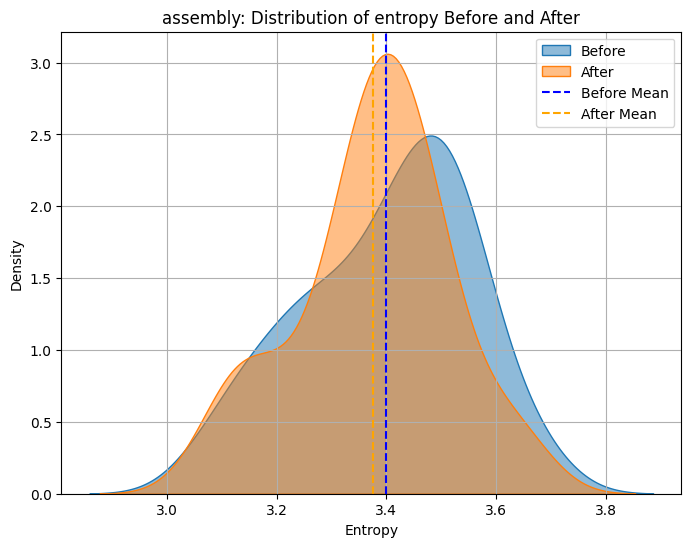

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


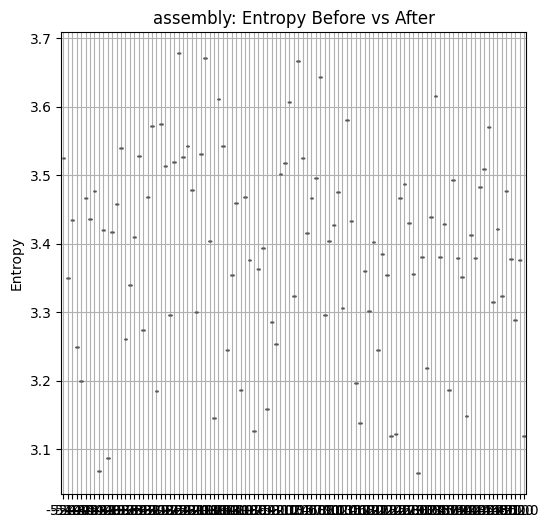

Analyzing c...


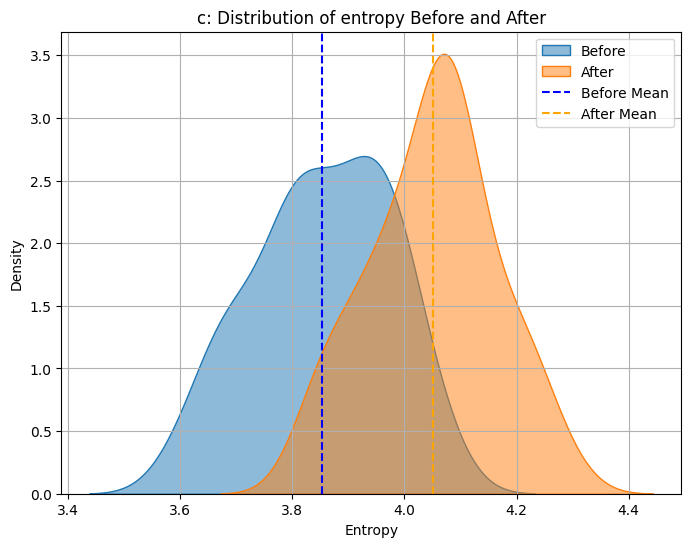

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


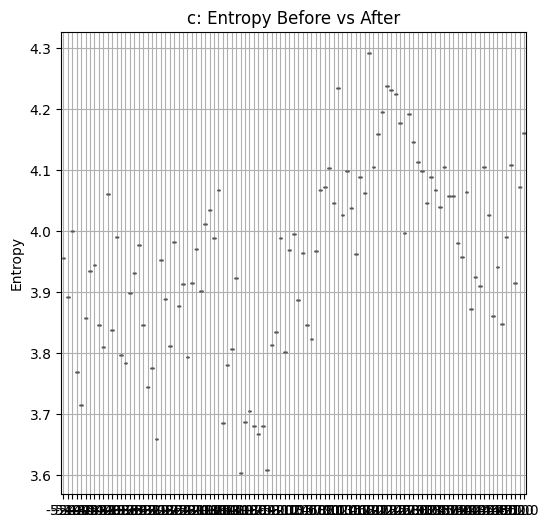

Analyzing c#...


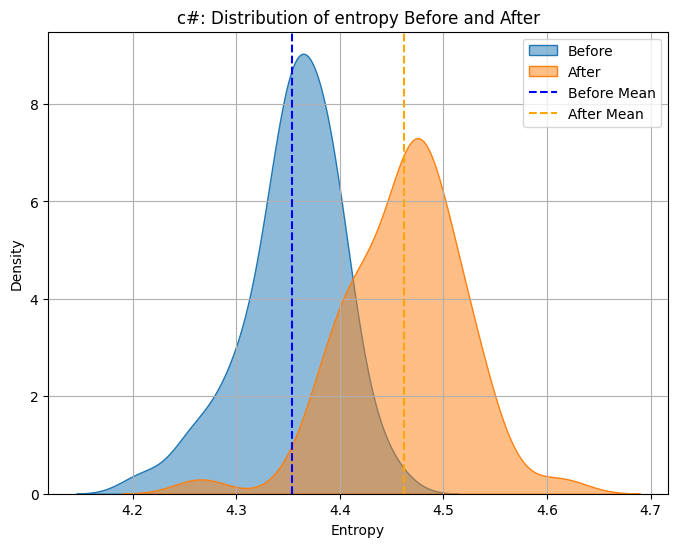

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


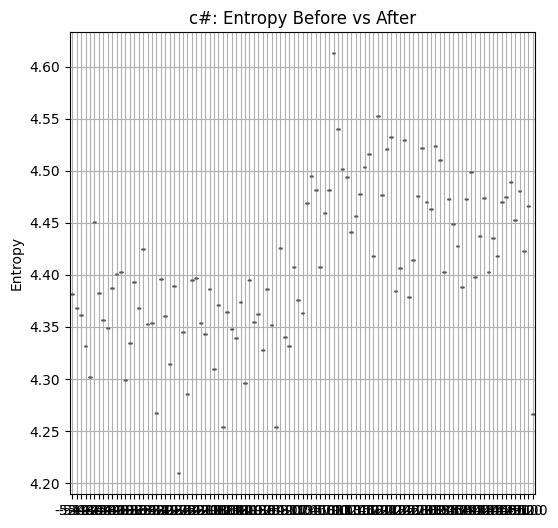

Analyzing c++...


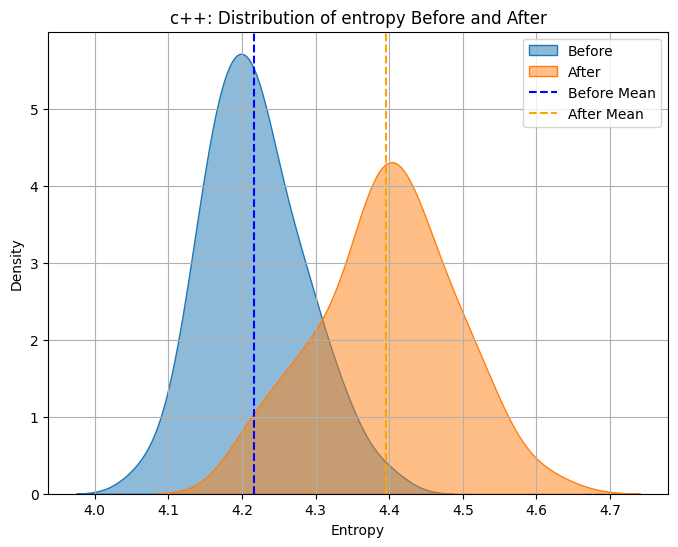

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


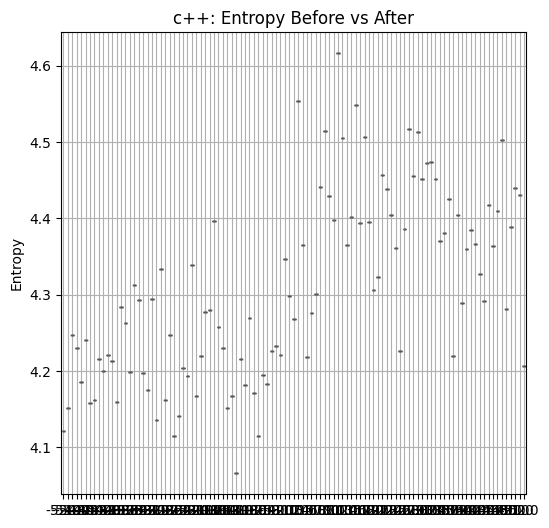

Analyzing go...


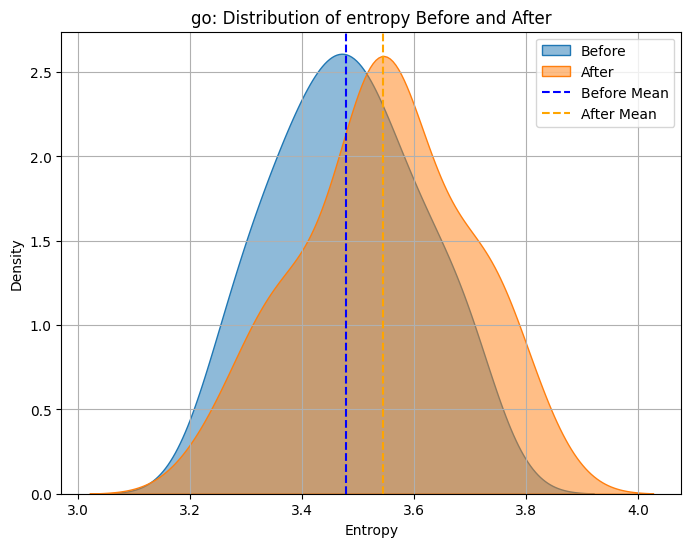

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


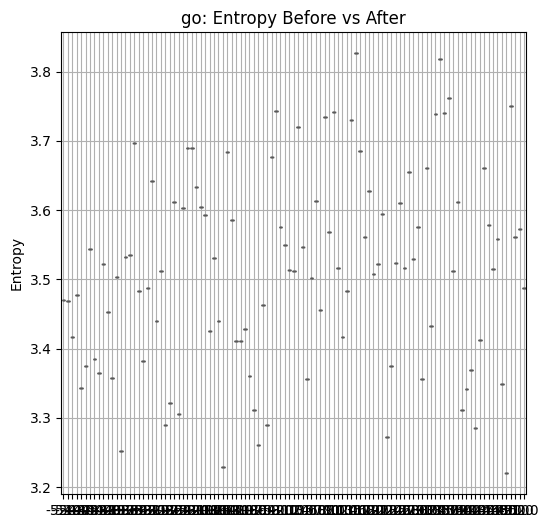

Analyzing java...


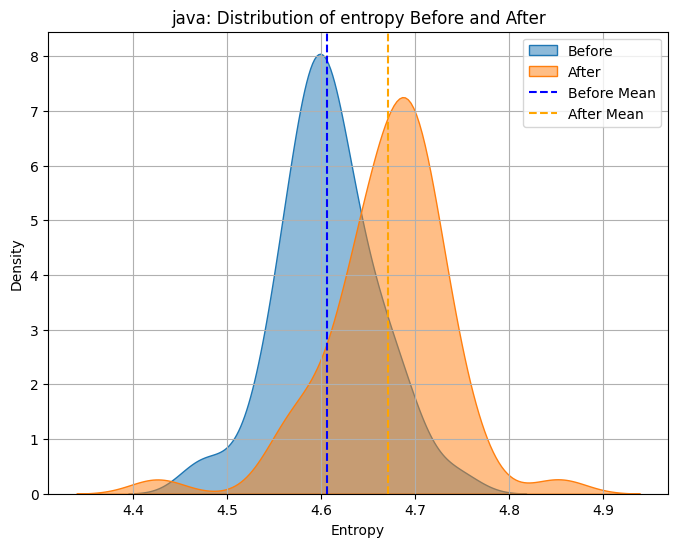

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


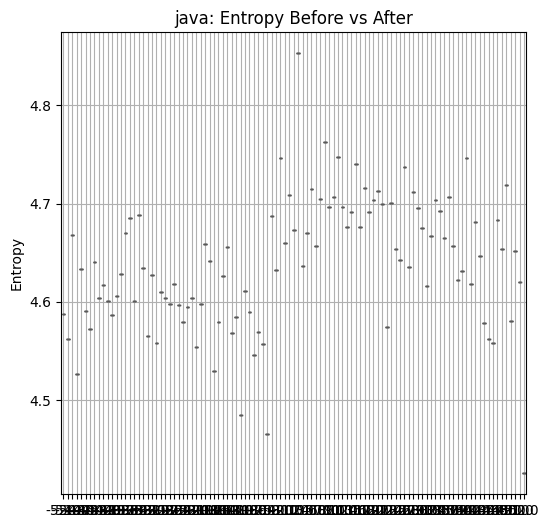

Analyzing javascript...


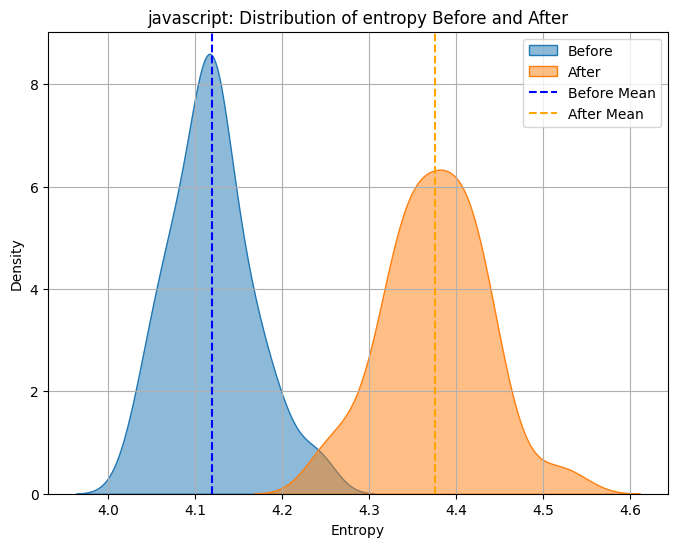

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


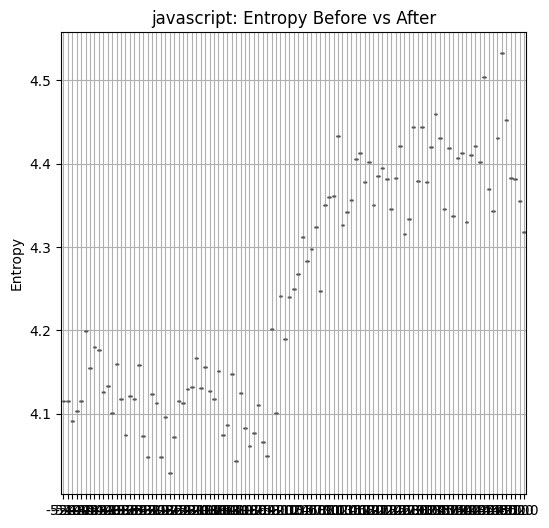

Analyzing kotlin...


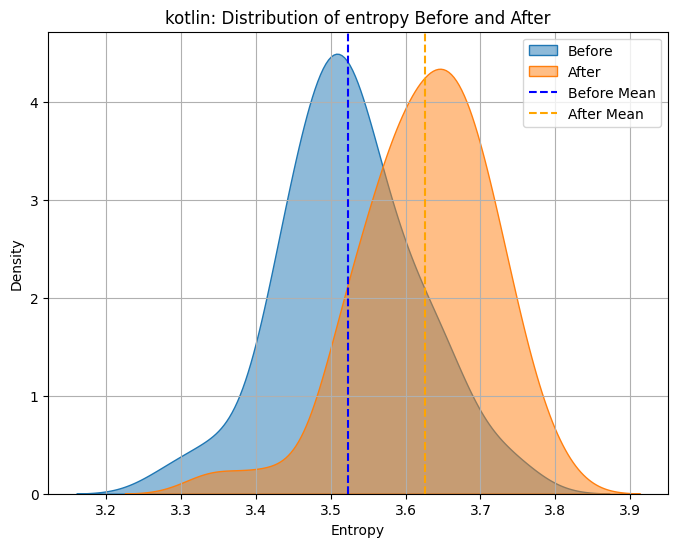

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


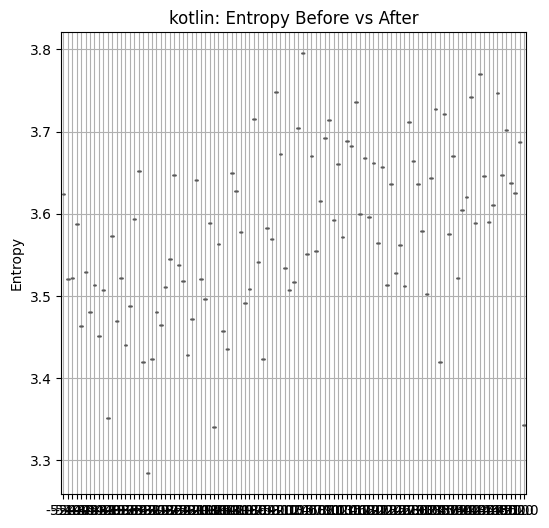

Analyzing objective-c...


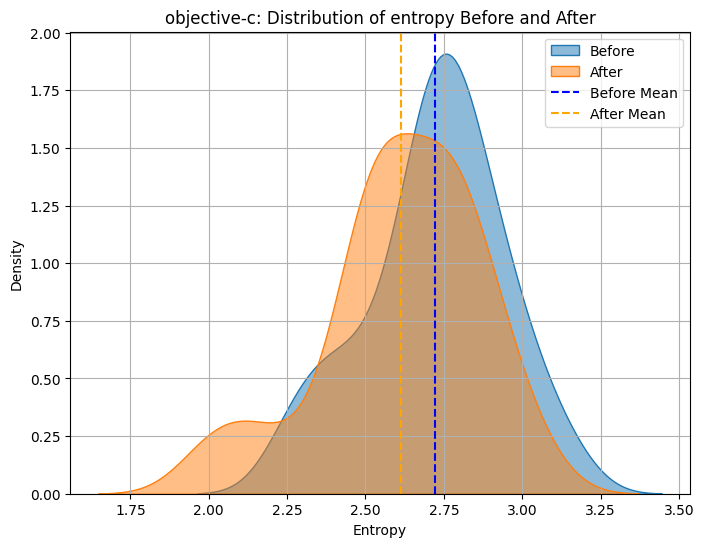

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


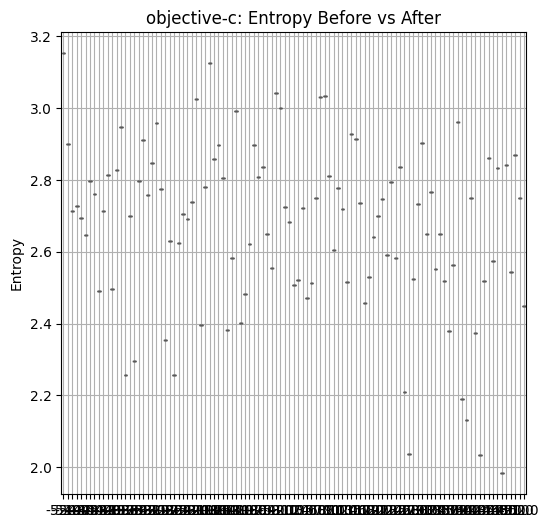

Analyzing python...


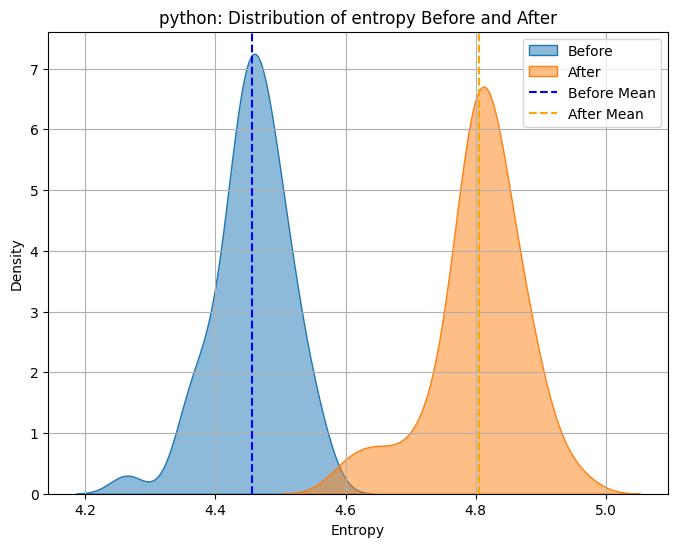

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


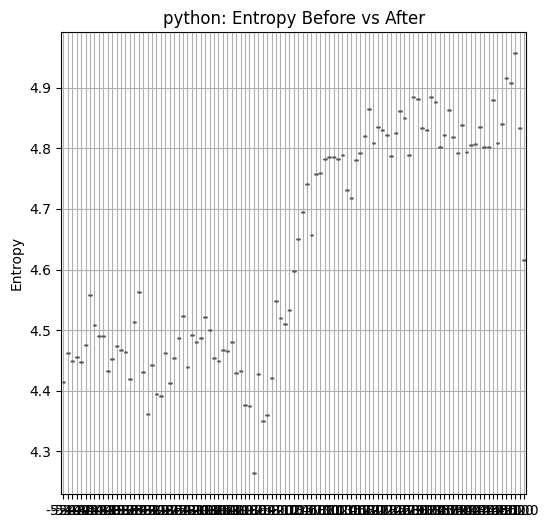

Analyzing r...


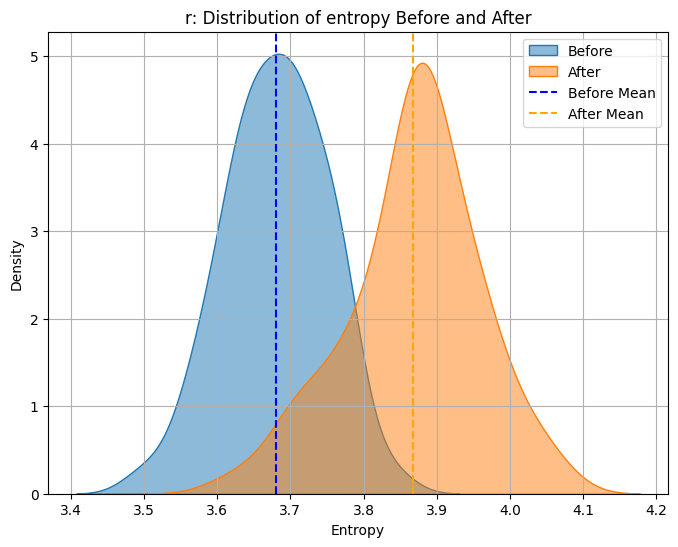

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


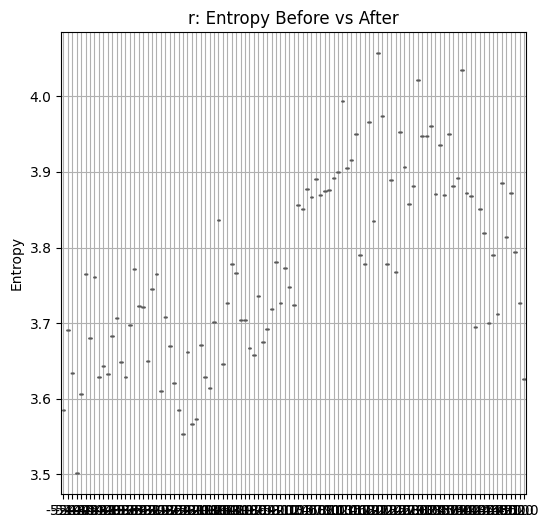

Analyzing ruby...


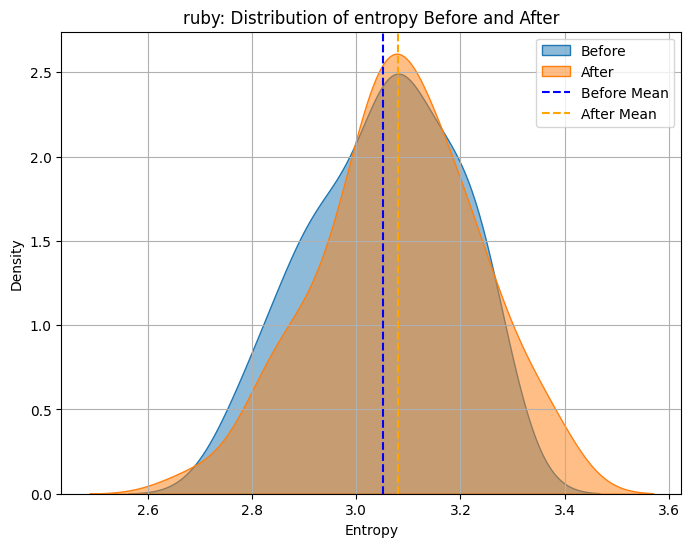

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


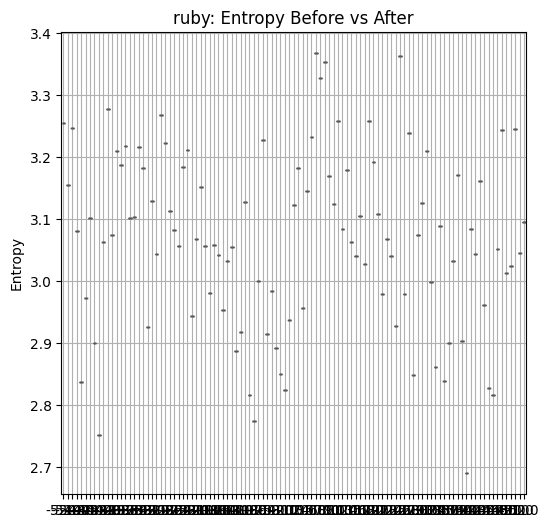

Analyzing rust...


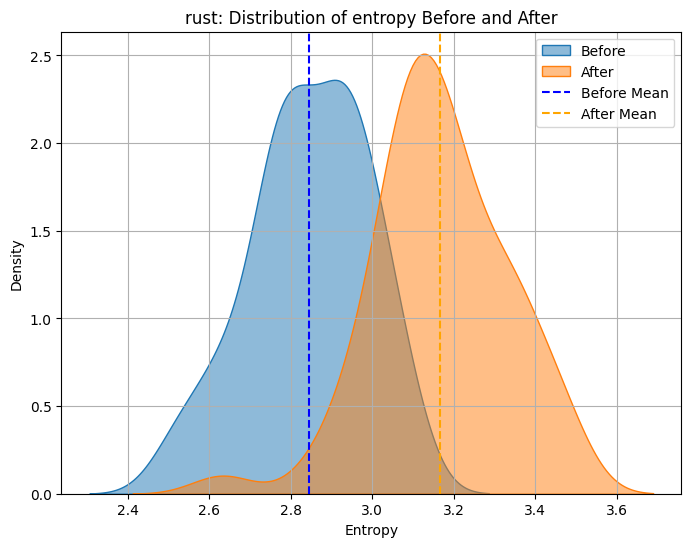

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


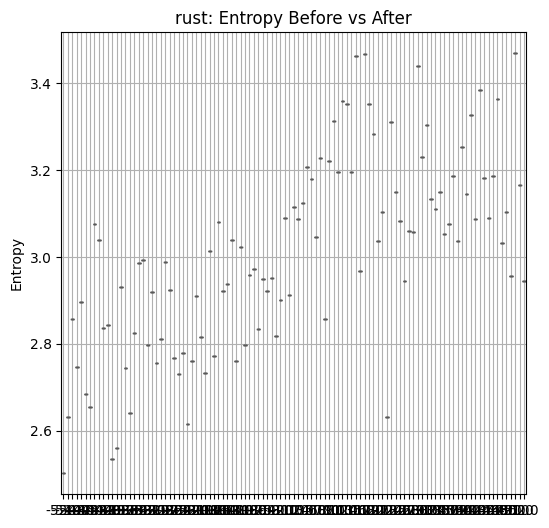

Analyzing scala...


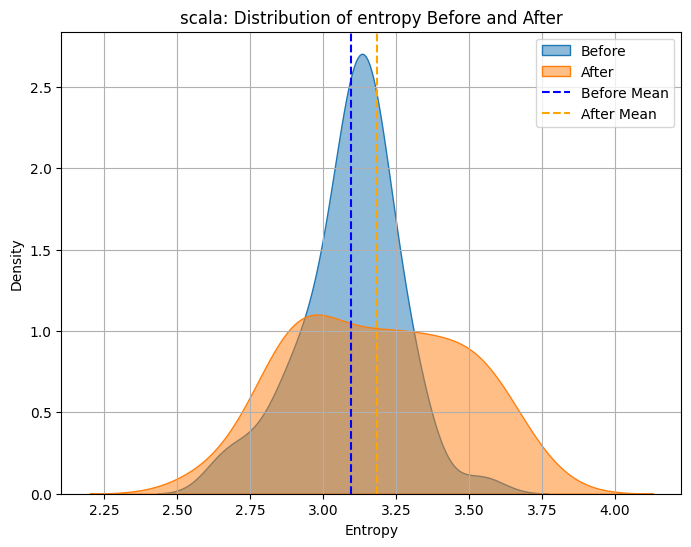

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


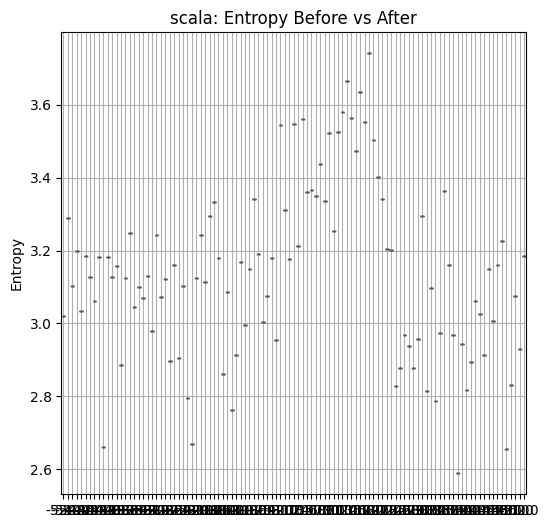

Analyzing sql...


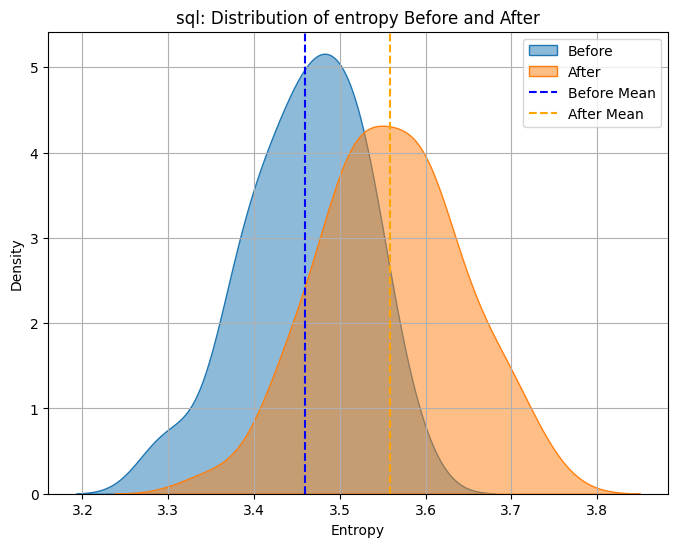

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


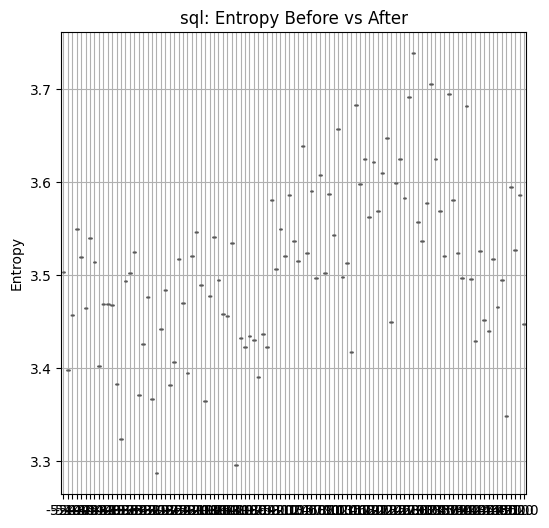

Analyzing swift...


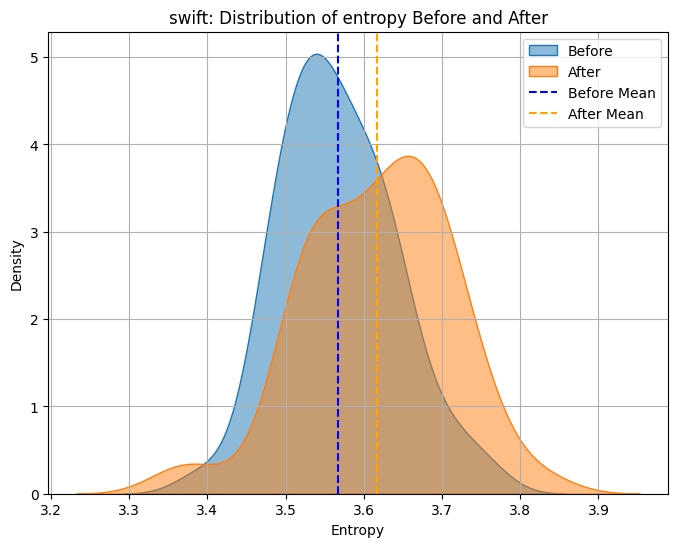

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


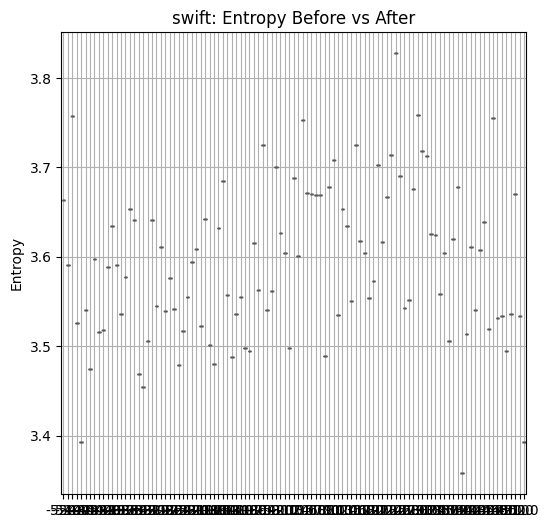

Analyzing typescript...


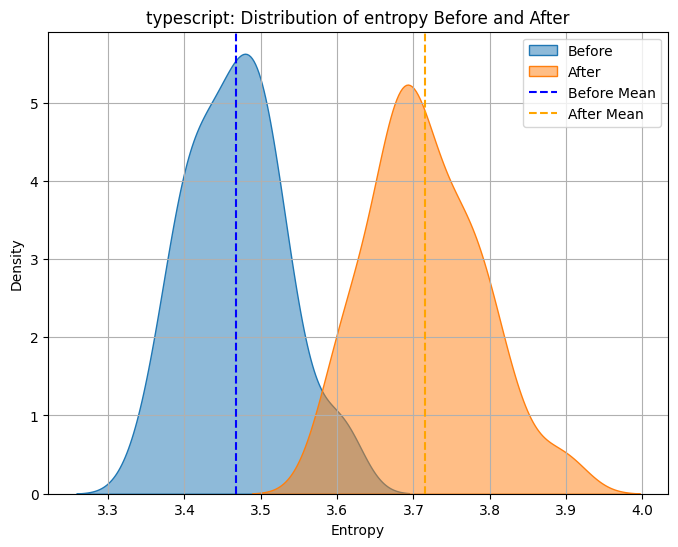

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


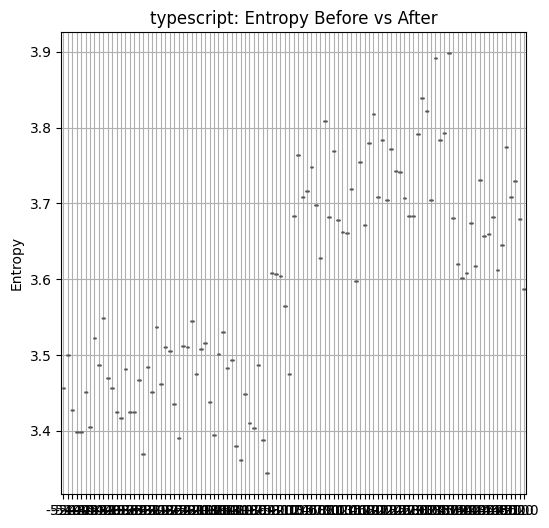

Analyzing vba...


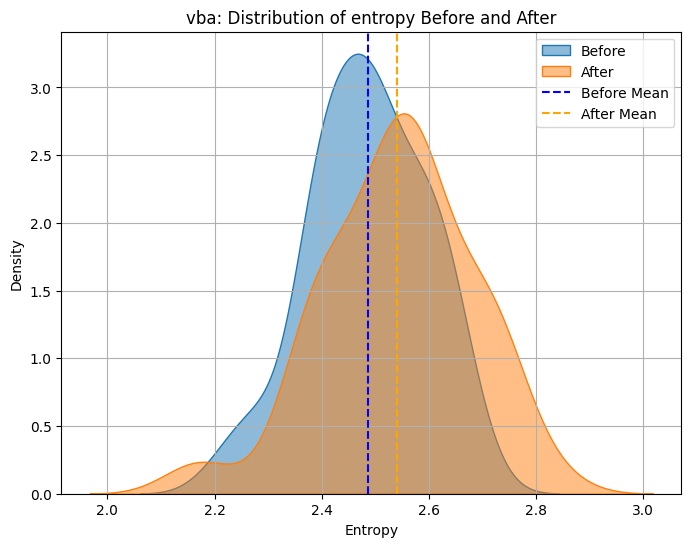

/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_21220/2908578436.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lang, x='rel_week', y=measure, palette='Set2')


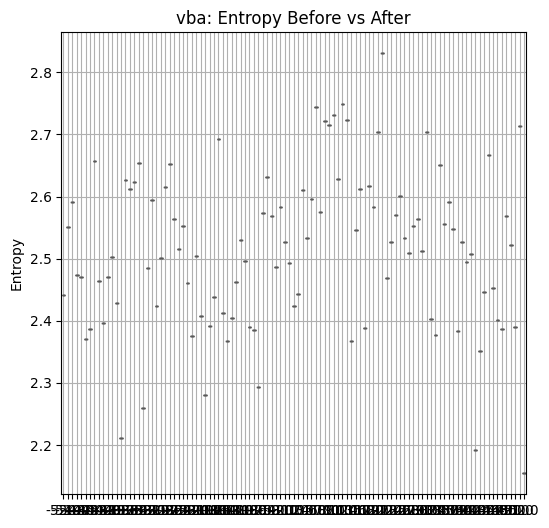

,Language,KS_pvalue,MW_pvalue,Mean_Before,Mean_After,Change_Direction
0,assembly,2.199296e-01,2.773264e-01,3.399796,3.376487,Decrease (↓)
1,c,1.046943e-09,1.168540e-11,3.853464,4.050379,Increase (↑)
2,c#,8.428130e-18,4.450096e-15,4.354199,4.461986,Increase (↑)
3,c++,9.184795e-15,1.225379e-14,4.216737,4.396075,Increase (↑)
4,go,5.130706e-02,2.050944e-02,3.478390,3.544969,Increase (↑)
5,java,3.159792e-08,3.889071e-08,4.606085,4.670533,Increase (↑)
6,javascript,6.377017e-31,1.060355e-18,4.119059,4.376109,Increase (↑)
7,kotlin,3.270256e-07,7.429893e-08,3.523366,3.626088,Increase (↑)
8,objective-c,4.188060e-02,3.996394e-02,2.721702,2.614971,Decrease (↓)
9,python,6.377017e-31,1.060355e-18,4.455453,4.804284,Increase (↑)


In [72]:
# 예를 들어, 데이터셋이 이런 구조라면:
# - matched_tags: 언어명
# - period: 'before' 또는 'after'
# - entropy: 엔트로피 값

# 실행
summary_table = analyze_and_plot_entropy(df_entropy_viz, measure='entropy')

# 결과 보기
display(summary_table)



In [70]:
df_entropy_viz

,rel_week,matched_tags,entropy,tot_cnt,log_tot_cnt
0,-52.0,assembly,3.524966,66.0,4.189655
1,-52.0,c,3.956435,553.0,6.315358
2,-52.0,c#,4.381750,1187.0,7.079184
3,-52.0,c++,4.121391,920.0,6.824374
4,-52.0,go,3.470481,157.0,5.056246
...,...,...,...,...,...
1885,52.0,scala,3.184345,25.0,3.218876
1886,52.0,sql,3.447426,219.0,5.389072
1887,52.0,swift,3.392896,153.0,5.030438
1888,52.0,typescript,3.587096,281.0,5.638355


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

def analyze_entropy_change(data, measure='entropy'):
    results = []

    languages = data['matched_tags'].unique()

    for lang in languages:
        df_lang = data[data['matched_tags'] == lang]
        before = df_lang[df_lang['rel_week'] < 0]['entropy']
        after  = df_lang[df_lang['rel_week'] >= 0]['entropy']
        

        if len(before) < 5 or len(after) < 5:
            continue  # 샘플 너무 적으면 스킵

        # 평균
        mean_before = before.mean()
        mean_after = after.mean()
        diff = mean_after - mean_before

        # 표준오차 (SE)와 95% 신뢰구간
        pooled_se = np.sqrt(before.var(ddof=1)/len(before) + after.var(ddof=1)/len(after))
        ci_low = diff - 1.96 * pooled_se
        ci_high = diff + 1.96 * pooled_se

        pval = mannwhitneyu(before, after, alternative='two-sided').pvalue

        results.append({
            'Language': lang,
            'Mean_Before': mean_before,
            'Mean_After': mean_after,
            'Diff': diff,
            'CI_Low': ci_low,
            'CI_High': ci_high,
            'pvalue': pval
        })

    summary_df = pd.DataFrame(results)
    return summary_df

In [121]:
import matplotlib.pyplot as plt

def plot_forest_with_significance(summary_df):
    summary_df = summary_df.sort_values('Diff')
    languages = summary_df['Language']
    diffs = summary_df['Diff']
    errors = [diffs - summary_df['CI_Low'], summary_df['CI_High'] - diffs]
    p_values = summary_df['pvalue']

    fig, ax = plt.subplots(figsize=(8, max(6, len(languages) * 0.3)))

        # 별표 추가
    significance = []
    for p in p_values:
        if p < 0.001:
            significance.append('***')
        elif p < 0.01:
            significance.append('**')
        elif p < 0.05:
            significance.append('*')
        else:
            significance.append('')

    labels = [f"{lang} ({sig})" if sig else lang for lang, sig in zip(languages, significance)]
    
    ax.errorbar(diffs, labels, xerr=errors, fmt='o', color='teal', ecolor='lightgray', elinewidth=2, capsize=4)
    ax.axvline(0, color='black', linestyle='--')
    ax.set_title('Language-wise Entropy Change')
    ax.set_xlabel('Change in Entropy After ChatGPT')
    ax.grid(True, axis='x')

    
    for label in ax.get_yticklabels():
        original_text = label.get_text()        # 예: "python***"
        clean_text = original_text.replace('*', '').replace('(', '').replace(')', '').replace(' ', '')  # "python" 으로 비교
        # 여기서 highlight_labels는 "언어명"만 들어 있어야 해 (별표 없이)
        # 그래서 text에서 별표 제거한 후 비교
        print(clean_text)
        if clean_text in lang_t5_2024:
            label.set_text(original_text)
            label.set_color('red')  # 강조할 언어는 빨간색
            print(original_text)
        elif clean_text in lang_b5_2024:
            label.set_text(original_text)
            label.set_color('blue')  # 강조할 언어는 빨간색
        else:
            label.set_text(original_text)
            label.set_color('black')  # 나머지는 검정색

    plt.tight_layout()
    plt.show()


objective-c
assembly
assembly
ruby
swift
swift (**)
vba
vba (*)
java
go
scala
scala
sql
kotlin
c#
c++
r
c
typescript
javascript
rust
rust (***)
python


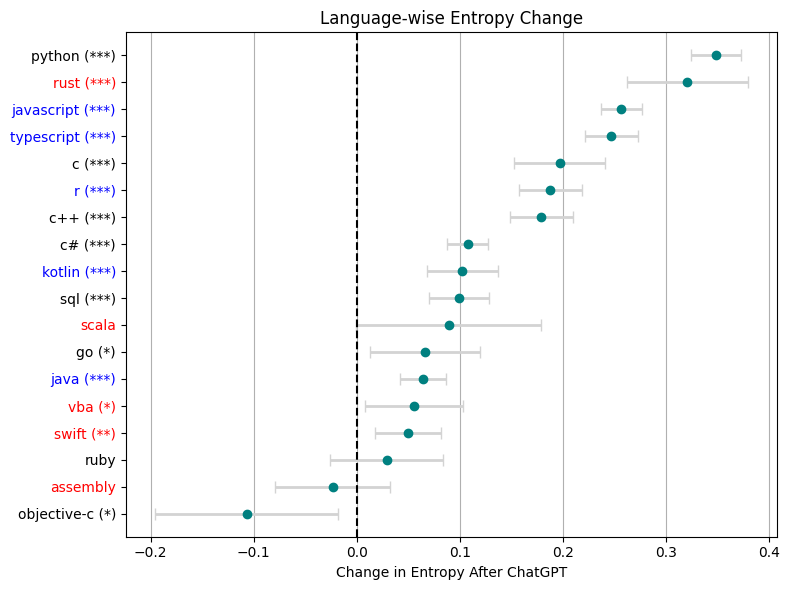

,Language,Mean_Before,Mean_After,Diff,CI_Low,CI_High,pvalue
0,assembly,3.399796,3.376487,-0.023309,-0.079151,0.032534,2.773264e-01
1,c,3.853464,4.050379,0.196914,0.152287,0.241541,1.168540e-11
2,c#,4.354199,4.461986,0.107786,0.087911,0.127662,4.450096e-15
3,c++,4.216737,4.396075,0.179338,0.148693,0.209984,1.225379e-14
4,go,3.478390,3.544969,0.066580,0.013323,0.119837,2.050944e-02
5,java,4.606085,4.670533,0.064448,0.042130,0.086765,3.889071e-08
6,javascript,4.119059,4.376109,0.257050,0.236748,0.277352,1.060355e-18
7,kotlin,3.523366,3.626088,0.102722,0.068649,0.136796,7.429893e-08
8,objective-c,2.721702,2.614971,-0.106730,-0.195422,-0.018038,3.996394e-02
9,python,4.455453,4.804284,0.348831,0.324344,0.373319,1.060355e-18


In [122]:
# (1) 데이터 준비
# data에는 'matched_tags' (언어명), 'period' (before/after), 'entropy' 컬럼이 있어야 해

# (2) 분석
summary_df = analyze_entropy_change(df_entropy_viz, measure='entropy')

plot_forest_with_significance(summary_df)

# (4) Summary 테이블도 확인 가능
display(summary_df)
